In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

pd.set_option("max_columns", 999)
pd.set_option("max_rows", 999)

In [327]:
Player_information = pd.read_csv('Player_info_added_perday.csv', engine='python')
Player_action = pd.read_csv('Player_action_added_perday.csv', engine='python')
Group_activity = pd.read_csv('Group_activity.csv', engine='python')
labeled_accounts = pd.read_csv('labeled_accounts.csv', engine='python')

# merge // get train and validation sets (get only the accounts labeled)

In [328]:
final = pd.merge(Player_information, Player_action, how='outer', on = "actor_account")
final = pd.merge(final, Group_activity, how='outer',  on = "actor_account")

In [329]:
model_data = pd.merge(final, labeled_accounts, how='inner', on = 'actor_account')
final.fillna(0, inplace=True)
print(final.shape)
final.head()

(8100, 32)


,actor_account,login_count,logout_count,login_day_count,play_time,avg_money,ip_count,max_level,playtime_per_day,sit_count,exp_get_amout,item_get_count,exp_repair_count,money_get_count,abyss,use_portal_count,killed_by_pc,killed_by_npc,teleport_count,reborn_count,question_count,login_total_day,sit_count_perday,item_get_count_perday,exp_repair_count_perday,money_get_count_perday,use_portal_count_perday,teleport_count_perday,total_party_time,guild_join_count,average_party_time,class
0,20000005,259,259,1,637926,124.849465,259,0,42528.40000,270,389149580,31149,0,4686,0,0,47,30,376,51,62,15,18.000000,2076.600000,0.0,312.400000,0.000000,25.066667,8862.0,0.0,1477.000000,0
1,20000016,38,37,1,401885,43.509962,38,42,28706.07143,153,80119427,61579,0,1596,0,0,32,75,343,75,5893,14,10.928571,4398.500000,0.0,114.000000,0.000000,24.500000,69458.0,0.0,3655.684211,0
2,20000033,43,42,1,240334,-6.613812,43,38,17166.71429,378,142485377,24686,0,1318,0,0,35,53,337,69,97,14,27.000000,1763.285714,0.0,94.142857,0.000000,24.071429,43619.0,0.0,2295.736842,0
3,20000035,25,24,1,1205493,0.088531,25,0,80366.20000,207,1377552887,109795,0,7979,0,0,0,12,44,10,0,15,13.800000,7319.666667,0.0,531.933333,0.000000,2.933333,0.0,0.0,0.000000,0
4,20000051,110,109,1,457433,-32.874878,110,0,30495.53333,320,395099069,98368,0,3551,0,1,311,109,568,261,80,15,21.333333,6557.866667,0.0,236.733333,0.066667,37.866667,40934.0,0.0,2558.375000,0


In [357]:
y = final.iloc[:, -1]

## Simple EDA

In [358]:
model_data = final.copy()

# Login_count and Logout_count is virtually the same. Remove Logout_count
del model_data['logout_count']

# check if there is any nan values
for i in model_data.columns:
    model_data[model_data[i] == np.nan]

# There are inf values. Change it to max value in the column
for i in model_data.columns:
    model_data.loc[model_data[i] == np.inf, i] = np.nan
    model_data.loc[np.isnan(model_data[i]), i] = max(model_data[i])

In [359]:
# ip count and login_count is the same delete one of them
np.unique(model_data['ip_count']/model_data['login_count'])
del model_data['ip_count']

In [360]:
# login_day_count is all 1 except for one row
print(np.unique(model_data['login_day_count']), np.count_nonzero(model_data['login_day_count']))
del model_data['login_day_count']

[0. 1.] 8099


# Create new columns

In [361]:
# Measure how patient the player is
m = model_data['sit_count'] / model_data['play_time'] 
m[m == np.inf] = 0
m[np.isnan(m)] = 0
print(np.corrcoef(m, y))
model_data['sit_count/play_time'] = m

[[1.         0.07671107]
 [0.07671107 1.        ]]


In [362]:
# the lesser you get killed by a player the more likely you are to be a bot
m = model_data['killed_by_pc'] / model_data['play_time'] 
m[m == np.inf] = 0
m[np.isnan(m)] = 0
print(np.corrcoef(m, y))
model_data['killed_by_pc/play_time'] = m

[[ 1.         -0.08847992]
 [-0.08847992  1.        ]]


In [363]:
# similar with above
m = model_data['killed_by_npc'] / model_data['play_time'] 
m[m == np.inf] = 0
m[np.isnan(m)] = 0
print(np.corrcoef(m, y))
model_data['killed_by_npc/play_time'] = m

[[ 1.         -0.07269662]
 [-0.07269662  1.        ]]


In [364]:
# How organized the palyer is 
m = model_data['total_party_time'] / model_data['play_time'] 
m[m == np.inf] = 0
m[np.isnan(m)] = 0
print(np.corrcoef(m, y))
model_data['total-party_time/play_time'] = m

[[ 1.         -0.13955735]
 [-0.13955735  1.        ]]


In [365]:
# How impatient the player is
m = model_data['teleport_count'] / model_data['play_time'] 
m[m == np.inf] = 0
m[np.isnan(m)] = 0
print(np.corrcoef(m, y))
model_data['teleport_count/play_time'] = m

[[ 1.        -0.1037434]
 [-0.1037434  1.       ]]


In [366]:
# How often the player takes a real rest
m = model_data['play_time'] / model_data['login_count'] 
m[m == np.inf] = 0
m[np.isnan(m)] = 0
print(np.corrcoef(m, y))
model_data['play_time/login_count'] = m

[[1.         0.21377834]
 [0.21377834 1.        ]]


In [367]:
# How efficient the player is 
m = model_data['exp_get_amout'] / model_data['play_time'] 
m[m == np.inf] = 0
m[np.isnan(m)] = 0
print(np.corrcoef(m, y))
model_data['exp_get_amount/play_time'] = m

[[ 1.         -0.24696058]
 [-0.24696058  1.        ]]


In [368]:
# How efficient the player is 
m = model_data['playtime_per_day'] / model_data['login_total_day'] 
m[m == np.inf] = 0
m[np.isnan(m)] = 0
print(np.corrcoef(m, y))
model_data['playtime_per_day/login_total_day'] = m

[[1.        0.3985221]
 [0.3985221 1.       ]]


In [369]:
# How efficient the player is 
m = model_data['max_level'] / model_data['login_count'] 
m[m == np.inf] = 0
m[np.isnan(m)] = 0
print(np.corrcoef(m, y))
model_data['max_level/login_count'] = m

[[1.        0.1213195]
 [0.1213195 1.       ]]


In [370]:
# How efficient the player is 
m = model_data['reborn_count'] / model_data['login_count'] 
m[m == np.inf] = 0
m[np.isnan(m)] = 0
print(np.corrcoef(m, y))
model_data['reborn_count/login_count'] = m

[[1.         0.19802241]
 [0.19802241 1.        ]]


In [371]:
# Humans do not sit a a lot when the level is high level
m = model_data['sit_count'] / model_data['max_level'] 
m[m == np.inf] = 0
m[np.isnan(m)] = 0
print(np.corrcoef(m, y))
model_data['sit_count/max_level'] = m

[[1.         0.23390367]
 [0.23390367 1.        ]]


In [372]:
# Bots do not finish quest
m = model_data['play_time'] / model_data['question_count'] 
m[m == np.inf] = 0
m[np.isnan(m)] = 0
print(np.corrcoef(m, y))
model_data['play_time/question_count'] = m

[[1.         0.21428974]
 [0.21428974 1.        ]]


## Do this automatically

for i in model_data:
    for j in model_data:
        m = model_data[j] / model_data[i] 
        m[m == np.inf] = 0
        m[np.isnan(m)] = 0
        x = np.corrcoef(m, y)[0][1]
        if abs(x) > 0.10:
            print(j, i, x)

## Correlation Cofficient 
    1. Actor_account is a dummy variable. Any variable that has a lower contribution than actor_account should be deleted
    2. Exp_repair_count a single value of 1. This should be deleted

In [373]:
for i in range(0, len(x.columns)):
    if abs(np.corrcoef(x.iloc[:,i], y)[0,1]) > abs(np.corrcoef(x['actor_account'], y)[0,1]):
        print(x.columns[i], np.corrcoef(x.iloc[:,i], y)[0,1])

login_count -0.05176935312645625
play_time 0.14294229185493634
max_level 0.09093472319491953
playtime_per_day 0.3749819266878865
sit_count 0.1238850846423584
exp_get_amout -0.11734438439216478
money_get_count 0.18601811721751838
abyss -0.052654698021253214
use_portal_count -0.08389118248457643
killed_by_pc -0.03356950907126214
teleport_count -0.04554341869495468
reborn_count 0.0846163330018644
login_total_day -0.14704220318195943
sit_count_perday 0.24494453878892125
item_get_count_perday 0.07589103723503555
money_get_count_perday 0.2465620112702065
use_portal_count_perday -0.08379207883530233
teleport_count_perday 0.04071646410226886
total_party_time -0.11445935957046192
guild_join_count -0.019502640900829173
average_party_time -0.04562800100341479
sit_count/play_time 0.07671106554755529
killed_by_pc/play_time -0.08847991794844628
killed_by_npc/play_time -0.07269662407919489
total-party_time/play_time -0.1395573484480958
teleport_count/play_time -0.10374339652184887
play_time/login_cou

In [374]:
del model_data['exp_repair_count']

In [375]:
x = model_data.drop(['class'], axis=1)

In [376]:
x.head()

,actor_account,login_count,play_time,avg_money,max_level,playtime_per_day,sit_count,exp_get_amout,item_get_count,money_get_count,abyss,use_portal_count,killed_by_pc,killed_by_npc,teleport_count,reborn_count,question_count,login_total_day,sit_count_perday,item_get_count_perday,exp_repair_count_perday,money_get_count_perday,use_portal_count_perday,teleport_count_perday,total_party_time,guild_join_count,average_party_time,sit_count/play_time,killed_by_pc/play_time,killed_by_npc/play_time,total-party_time/play_time,teleport_count/play_time,play_time/login_count,exp_get_amount/play_time,playtime_per_day/login_total_day,max_level/login_count,reborn_count/login_count,sit_count/max_level,play_time/question_count
0,20000005.0,259.0,637926.0,124.849465,0.0,42528.40000,270.0,3.891496e+08,31149.0,4686.0,0.0,0.0,47.0,30.0,376.0,51.0,62.0,15.0,18.000000,2076.600000,0.0,312.400000,0.000000,25.066667,8862.0,0.0,1477.000000,0.000423,0.000074,0.000047,0.013892,0.000589,2463.034749,610.023075,2835.226667,0.000000,0.196911,0.000000,10289.129032
1,20000016.0,38.0,401885.0,43.509962,42.0,28706.07143,153.0,8.011943e+07,61579.0,1596.0,0.0,0.0,32.0,75.0,343.0,75.0,5893.0,14.0,10.928571,4398.500000,0.0,114.000000,0.000000,24.500000,69458.0,0.0,3655.684211,0.000381,0.000080,0.000187,0.172831,0.000853,10575.921053,199.359088,2050.433674,1.105263,1.973684,3.642857,68.197013
2,20000033.0,43.0,240334.0,-6.613812,38.0,17166.71429,378.0,1.424854e+08,24686.0,1318.0,0.0,0.0,35.0,53.0,337.0,69.0,97.0,14.0,27.000000,1763.285714,0.0,94.142857,0.000000,24.071429,43619.0,0.0,2295.736842,0.001573,0.000146,0.000221,0.181493,0.001402,5589.162791,592.864002,1226.193878,0.883721,1.604651,9.947368,2477.670103
3,20000035.0,25.0,1205493.0,0.088531,0.0,80366.20000,207.0,1.377553e+09,109795.0,7979.0,0.0,0.0,0.0,12.0,44.0,10.0,0.0,15.0,13.800000,7319.666667,0.0,531.933333,0.000000,2.933333,0.0,0.0,0.000000,0.000172,0.000000,0.000010,0.000000,0.000036,48219.720000,1142.729893,5357.746667,0.000000,0.400000,0.000000,0.000000
4,20000051.0,110.0,457433.0,-32.874878,0.0,30495.53333,320.0,3.950991e+08,98368.0,3551.0,0.0,1.0,311.0,109.0,568.0,261.0,80.0,15.0,21.333333,6557.866667,0.0,236.733333,0.066667,37.866667,40934.0,0.0,2558.375000,0.000700,0.000680,0.000238,0.089486,0.001242,4158.481818,863.731014,2033.035555,0.000000,2.372727,0.000000,5717.912500


## Lasso (Model Based Feature Selection)

In [377]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.3)

lasso = Lasso().fit(x_train, y_train)

print('{:.3f}'.format(lasso.score(x_train, y_train)))
print('{:.3f}'.format(lasso.score(x_test, y_test)))

0.386
0.375


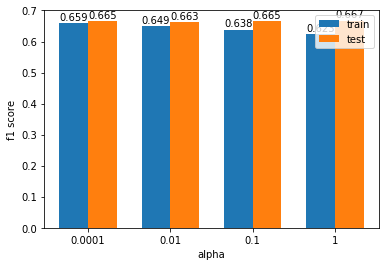

In [378]:
import matplotlib.pyplot as plt

alpha_set = [0.0001, 0.01, 0.1, 1]
max_inter_set = [10000000, 100000, 10000, 1000]

train_score = []
test_score = []
used_feature = []

for a, m in zip(alpha_set, max_inter_set):
    lasso_tr_y = lasso.predict(x_train)
    lasso_t_y = lasso.predict(x_test)
    lasso = Lasso(alpha=a, max_iter=m).fit(x_train, y_train)
    la_tr_score = np.round(f1_score((lasso.predict(x_train) > np.percentile(lasso_tr_y, 93)).astype(int), y_train), 3)
    la_te_score = np.round(f1_score((lasso.predict(x_test) > np.percentile(lasso_t_y, 93)).astype(int), y_test), 3)
    number_used = np.sum(lasso.coef_ != 0)

    train_score.append(la_tr_score)
    test_score.append(la_te_score)
    used_feature.append(number_used)

index = np.arange(len(alpha_set))
bar_width = 0.35
plt.bar(index, train_score, width=bar_width, label='train')
plt.bar(index+bar_width, test_score, width=bar_width, label='test')
plt.xticks(index+bar_width/2, alpha_set) # bar그래프 dodge를 하기 위해 기준값에 보정치를 더해줍니다.


for i, (ts, te) in enumerate(zip(train_score, test_score)):
    plt.text(i, ts+0.01, str(ts), horizontalalignment='center')
    plt.text(i+bar_width, te+0.01, str(te), horizontalalignment='center')

plt.legend(loc=1, )
plt.xlabel('alpha')
plt.ylabel('f1 score')
plt.show()

## Results of Feature Selection by Lasso

In [379]:
# when alpha is 1

lasso = Lasso(alpha=1, max_iter=1000).fit(x_train, y_train)

lasso_tr_y = lasso.predict(x_train)
lasso_t_y = lasso.predict(x_test)

for i in range(0, len(x.columns)):
    if abs(lasso.coef_[i]) > abs(lasso.coef_[0]):
        print(x.columns[i], lasso.coef_[i])

login_count -7.431591038084831e-07
play_time -5.818525453478022e-07
avg_money 5.329122401155106e-07
playtime_per_day 1.3998491901765435e-05
sit_count 8.2663857091499e-06
item_get_count 3.2519550629214985e-07
money_get_count 4.250360575737557e-06
teleport_count -2.2946709755633021e-07
item_get_count_perday -3.711941168406754e-06
money_get_count_perday 1.2600130292372436e-05
total_party_time -6.605963867086389e-07
average_party_time 5.360961331663716e-07
play_time/login_count -2.5761110367991125e-06
exp_get_amount/play_time -5.521631853234836e-06
playtime_per_day/login_total_day -2.9594218416721964e-06
play_time/question_count 1.969591826025726e-07


In [380]:
# when alpha is 0.1

lasso = Lasso(alpha=0.1, max_iter=10000).fit(x_train, y_train)

lasso_tr_y = lasso.predict(x_train)
lasso_t_y = lasso.predict(x_test)

for i in range(0, len(x.columns)):
    if abs(lasso.coef_[i]) > abs(lasso.coef_[0]):
        print(x.columns[i], lasso.coef_[i])

login_count -6.173336055568963e-05
play_time -4.6879356846450035e-07
avg_money 5.971366903188717e-07
playtime_per_day 1.2607707861796564e-05
sit_count -1.902749786570579e-05
item_get_count 3.4973455128266695e-07
money_get_count 2.0882150309011726e-06
killed_by_pc -0.00012708058572396289
killed_by_npc -0.00011375343578603205
teleport_count -4.5184421138882115e-05
reborn_count 0.00015781036645903988
question_count -2.834292924080243e-06
sit_count_perday 0.00029987727399113023
item_get_count_perday -3.7176124848772324e-06
money_get_count_perday 3.683145481919585e-05
total_party_time -5.279860287972878e-07
average_party_time 4.300387548407576e-07
play_time/login_count -3.260060281068358e-06
exp_get_amount/play_time -1.0166999081660696e-05
playtime_per_day/login_total_day -2.13309067285731e-06
sit_count/max_level 0.00032634781311151713
play_time/question_count 1.794890826319708e-07


In [381]:
# when alpha is 0.01

lasso = Lasso(alpha=0.01, max_iter=100000).fit(x_train, y_train)

lasso_tr_y = lasso.predict(x_train)
lasso_t_y = lasso.predict(x_test)

for i in range(0, len(x.columns)):
    if abs(lasso.coef_[i]) > abs(lasso.coef_[0]):
        print(x.columns[i], lasso.coef_[i])

login_count -7.763119951346674e-05
play_time -5.80975742684845e-07
avg_money 4.864248891460464e-07
playtime_per_day 1.4089727039727799e-05
sit_count -2.2954086566803856e-05
item_get_count 2.9512798595618544e-07
money_get_count 2.018978553880747e-06
abyss -3.4176878918400803e-07
killed_by_pc -0.00018589599892096463
killed_by_npc -0.00019701808841332053
teleport_count 0.00019317139526629272
reborn_count 0.00026950040507269624
question_count -3.568114313165259e-06
login_total_day 0.0006940472578572397
sit_count_perday 0.00032385719030963257
item_get_count_perday -3.1894319350653924e-06
money_get_count_perday 3.536818801691697e-05
teleport_count_perday -0.003850088071032824
total_party_time -5.31636111153742e-07
average_party_time 4.5837526995473064e-07
play_time/login_count -3.6516293481032657e-06
exp_get_amount/play_time -4.016053141193091e-06
playtime_per_day/login_total_day -2.1111646693035964e-06
max_level/login_count 0.0010754140470329474
sit_count/max_level 0.0005080635895867036
pla

In [384]:
model_data.head()

,actor_account,login_count,play_time,avg_money,max_level,playtime_per_day,sit_count,exp_get_amout,item_get_count,money_get_count,abyss,use_portal_count,killed_by_pc,killed_by_npc,teleport_count,reborn_count,question_count,login_total_day,sit_count_perday,item_get_count_perday,exp_repair_count_perday,money_get_count_perday,use_portal_count_perday,teleport_count_perday,total_party_time,guild_join_count,average_party_time,class,sit_count/play_time,killed_by_pc/play_time,killed_by_npc/play_time,total-party_time/play_time,teleport_count/play_time,play_time/login_count,exp_get_amount/play_time,playtime_per_day/login_total_day,max_level/login_count,reborn_count/login_count,sit_count/max_level,play_time/question_count
0,20000005.0,259.0,637926.0,124.849465,0.0,42528.40000,270.0,3.891496e+08,31149.0,4686.0,0.0,0.0,47.0,30.0,376.0,51.0,62.0,15.0,18.000000,2076.600000,0.0,312.400000,0.000000,25.066667,8862.0,0.0,1477.000000,0.0,0.000423,0.000074,0.000047,0.013892,0.000589,2463.034749,610.023075,2835.226667,0.000000,0.196911,0.000000,10289.129032
1,20000016.0,38.0,401885.0,43.509962,42.0,28706.07143,153.0,8.011943e+07,61579.0,1596.0,0.0,0.0,32.0,75.0,343.0,75.0,5893.0,14.0,10.928571,4398.500000,0.0,114.000000,0.000000,24.500000,69458.0,0.0,3655.684211,0.0,0.000381,0.000080,0.000187,0.172831,0.000853,10575.921053,199.359088,2050.433674,1.105263,1.973684,3.642857,68.197013
2,20000033.0,43.0,240334.0,-6.613812,38.0,17166.71429,378.0,1.424854e+08,24686.0,1318.0,0.0,0.0,35.0,53.0,337.0,69.0,97.0,14.0,27.000000,1763.285714,0.0,94.142857,0.000000,24.071429,43619.0,0.0,2295.736842,0.0,0.001573,0.000146,0.000221,0.181493,0.001402,5589.162791,592.864002,1226.193878,0.883721,1.604651,9.947368,2477.670103
3,20000035.0,25.0,1205493.0,0.088531,0.0,80366.20000,207.0,1.377553e+09,109795.0,7979.0,0.0,0.0,0.0,12.0,44.0,10.0,0.0,15.0,13.800000,7319.666667,0.0,531.933333,0.000000,2.933333,0.0,0.0,0.000000,0.0,0.000172,0.000000,0.000010,0.000000,0.000036,48219.720000,1142.729893,5357.746667,0.000000,0.400000,0.000000,0.000000
4,20000051.0,110.0,457433.0,-32.874878,0.0,30495.53333,320.0,3.950991e+08,98368.0,3551.0,0.0,1.0,311.0,109.0,568.0,261.0,80.0,15.0,21.333333,6557.866667,0.0,236.733333,0.066667,37.866667,40934.0,0.0,2558.375000,0.0,0.000700,0.000680,0.000238,0.089486,0.001242,4158.481818,863.731014,2033.035555,0.000000,2.372727,0.000000,5717.912500


# Creating Final Training Data

In [385]:
final_data = pd.DataFrame

In [395]:
# Through inspection of each columns
final_data = model_data[['login_count', 'play_time', 'max_level', "playtime_per_day", 'abyss', 'sit_count', 'exp_get_amout', 'money_get_count', 'teleport_count', 'killed_by_pc', 'killed_by_npc', 'reborn_count', 'login_total_day', 'sit_count_perday', 'login_total_day', 'item_get_count_perday', 'money_get_count_perday', 'use_portal_count_perday', 'teleport_count_perday', 'total_party_time', 'sit_count/play_time', 'killed_by_pc/play_time', 'killed_by_npc/play_time', 'total-party_time/play_time', 'teleport_count/play_time', 'play_time/login_count', 'exp_get_amount/play_time', 'playtime_per_day/login_total_day', 'max_level/login_count', 'reborn_count/login_count', 'sit_count/max_level', 'play_time/question_count' ]]

In [398]:
final_data['class'] = y

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [402]:
final_data.to_csv('data_perday_alpha.csv')